In [1]:
import pickle
import torch

# Specify the path to your pickle file
pickle_file_path = 'results/11-9-14:38:47.config.pkl'
    
# Load the pickle file
with open(pickle_file_path, 'rb') as file:
    config = pickle.load(file)

from CellPLM.model import OmicsFormer

config['projection'] = False

model = OmicsFormer(**config)

path = '/data/civy/integration/11-9-14:42:40_with_token_test.pt'

model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [4]:
import scanpy as sc
from scipy import  sparse

import torch

data = sc.read_h5ad('2000.h5ad')
if 'platform' not in data.obs:
    data.obs['platform'] = 'scRNA-seq'
if 'Dataset' not in data.obs:
    data.obs['Dataset'] = data.obs['study']
if 'batch_label' in data.obs:
    data.obs['batch'] = data.obs['batch_label']
gene_list = data.var.index.to_list()
gene_dict = dict(zip(data.obs['Dataset'].unique(), [torch.ones(len(gene_list)).bool()] * data.obs['Dataset'].nunique()))
ndataset = data.obs['Dataset'].nunique()


from CellPLM.utils.data import XDict, clean_batches, balanced_partition, data_setup

seq_list, batch_list, batch_labels, order_list, dataset_list, coord_list, label_list = data_setup(data, return_sparse=True)

partitions = balanced_partition(batch_list, 1)

In [9]:
import numpy as np 
import torch
import random
import pandas as pd


rank=0

model.cuda(rank)
model.eval()

attens = []

partition = partitions[0]

batch_index = 1

i = batch_index

x = torch.sparse_csr_tensor(seq_list[0][i], seq_list[1][i], seq_list[2][i],
                        seq_list[3][i].tolist()).to_sparse().float().coalesce()
x_dict = XDict({'x_seq': x.cuda(rank),  # seq_list[i].cuda(rank),
                'batch': batch_list[i].cuda(rank),
                'coord': coord_list[i].cuda(rank),
                'gene_mask': torch.ones([x.shape[1]]).bool().cuda(),
                'dataset': dataset_list[i].cuda(rank),
                'dropout': np.random.beta(config['beta'][0], config['beta'][1]),
                })
out_dict, attens = model.get_representation(x_dict)

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerActivation
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
import numpy as np 

output_attentions = torch.stack(attens)

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def draw_heatmap(input_matrix, label):
    plt.figure(figsize=(20, 16))
    normalized_matrix = input_matrix / (np.max(input_matrix) - np.min(input_matrix))
    sns.heatmap(normalized_matrix, cmap='viridis', annot=False, fmt=".2f", cbar=False, xticklabels=label, yticklabels=label)
    return

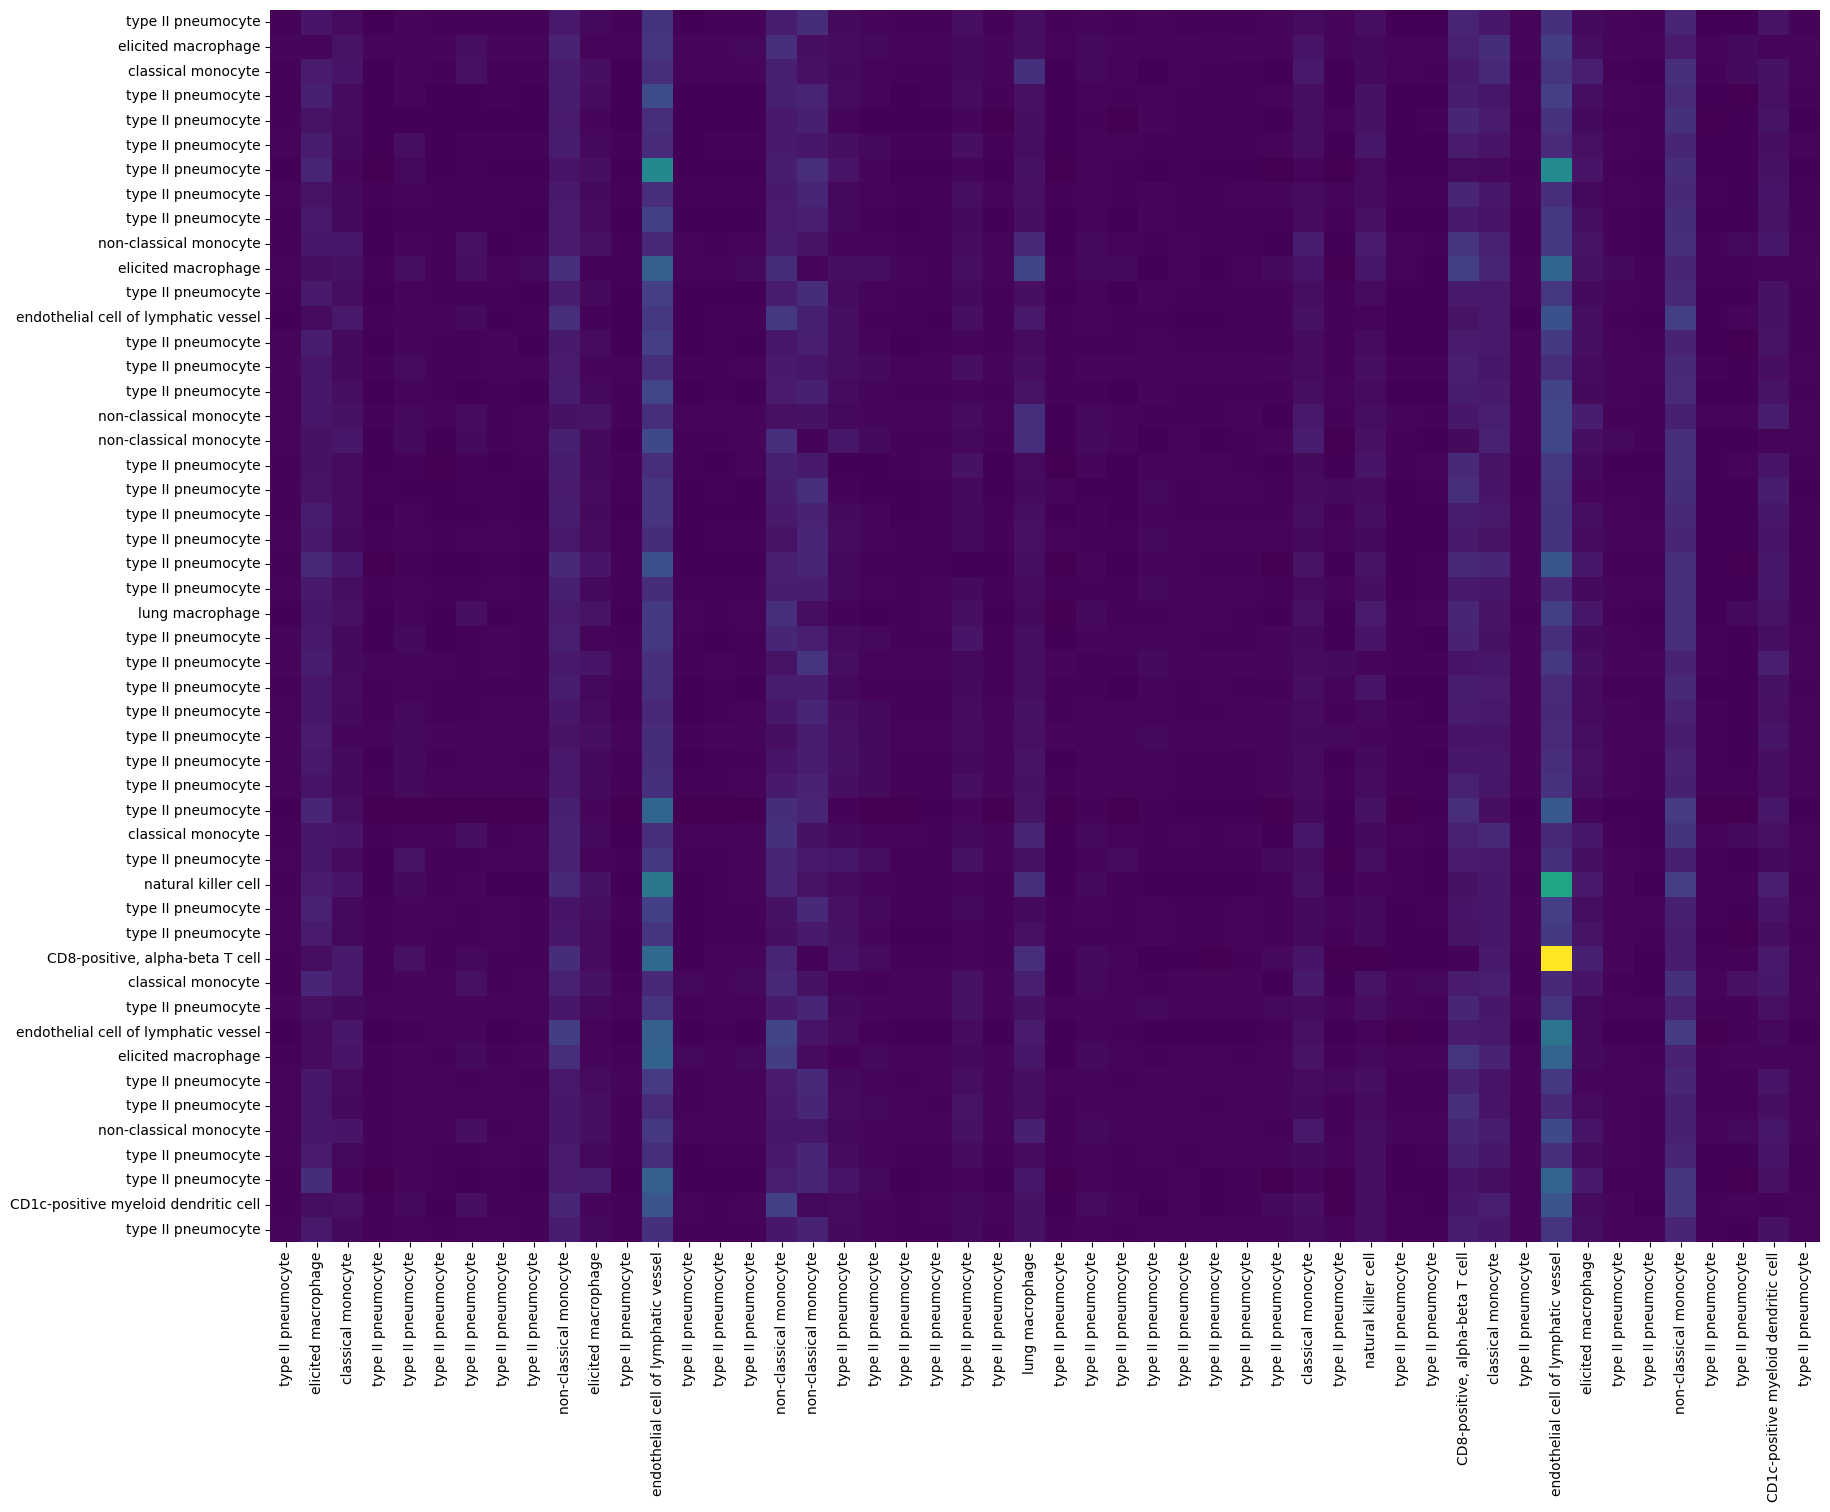

In [14]:
from sklearn.preprocessing import  LabelEncoder

def reverse_map(label, adata):
    label_encoder = LabelEncoder().fit(adata.obs['cell_type'])
    return label_encoder.inverse_transform(label)

draw_heatmap(output_attentions[0].squeeze().detach().cpu().numpy()[:50, :50], reverse_map(label_list[batch_index].cpu().numpy()[:50], data))